# 6. Estudio sobre aeropuertos. 

En este capítulo se analizan los aeropuertos según los siguientes indicadores:

- volumen de los vuelos totales, 
- volumen de vuelos retrasado 
- volumen de vuelos cancelados

También se analizan las causas principales y más comunes detro de los vuelos retrasados. Dichas causas son las que aquí se incluyen:

- causas debidas al avión
- causas debidas al tiempo
- causas debidas a la seguridad
- causas debidas a sistemas de navegavión
- causas debidas al transportista

Por último, se analiza un parámetro que indica el **número de minutos de retraso acumulados** que además de los vuelos retrasados, da una idea de la importancia del tiempo de retraso en el aeropuerto. 

## 6.1 Importación de librerías necesarias

Inicialmente se cargan las librerías de python necesarias.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

## 6.2 Conexión con MONGO ATLAS / LOCAL

In [2]:
#Mongo Atlas
#URI ="mongodb://sato:<PASSWORD>@satoclusterfaa-shard-00-00-gst6h.\
#azure.mongodb.net:27017,satoclusterfaa-shard-00-01-gst6h.azure.\
#mongodb.net:27017,satoclusterfaa-shard-00-02-gst6h.azure.mongodb\
#.net:27017/test?ssl=true&replicaSet=SatoClusterFAA-shard-0&authSource=admin&retryWrites=true"

#client = MongoClient(URI)
#db = client.FAA_Airlines

#local
client = MongoClient()#"mongodb://localhost:27017")
db = client.airports

Se crea la variable **air** para facilitar las consultas.

In [3]:
air = db.airlines

## 6.3 Evolución histórica de Ratios Vuelos Puntuales, Retrasados y Cancelados respecto a Vuelos Totales por aeropuerto. 

En este apartado se va a extraer la evolución histórica, dentro del período de estudio, de los **ratios de vuelos puntuales, retrasados y cancelados respecto a los vuelos totales por aeropuerto**.

Para ello, se realiza la siguiente consulta en la que:

- se filtran los años de interés
- se agrupa por aeropuerto, año y mes
- en dicha agrupación, se calcula la suma de:

    - vuelos retrasados
    - vuelos cancelados
    - vuelos puntuales

- se crean los campos:

    - ratios vuelos retrasados
    - vuelos vuelos cancelados
    - vuelos vuelos puntuales
    

Además, de la consulta, se va a **generar una colección "Histórico Aeropuertos"** para facilitar las consultas posteriores..

- **Query 10**

In [4]:
pipeline9 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": 
                        {"Aeropuerto": "$airport.code", "year": "$time.year", "month": "$time.month"},
                         "Totales": {"$sum": "$statistics.flights.total"},
                         "Retrasados": {"$sum": "$statistics.flights.delayed"},
                         "Cancelados": {"$sum": "$statistics.flights.cancelled"},
                         "Puntuales": {"$sum": "$statistics.flights.on time"}
                        }
             },
             {"$project": {
                          "Ratio_Retrasados": {"$divide": ["$Retrasados", "$Totales"]},
                          "Ratio_Cancelados": {"$divide": ["$Cancelados", "$Totales"]},
                          "Ratio_Puntuales": {"$divide": ["$Puntuales", "$Totales"]}
                          }
             },
             {"$out": "Historico_Aeropuertos"}
             
            ]

air.aggregate(pipeline9);

Se crea la variable **Ads** para facilitar las consultas. 

In [5]:
#Se almacena la colección en una variable
Ads = db.Historico_Aeropuertos

Una vez obtenida la nueva colección, se procede a utilizarla.

## 6.4 Aeropuertos con peores Ratios de Vuelos Puntuales, Retrasados y Cancelados respecto a Vuelos Totales por aeropuerto. 

Partiendo de la colección creada, se plantéa la pregunta de cuáles son los **aeropuertos que peores Ratios medios han tenido**, durante los años de estudio.

Para esta pregunta se plantea la siguiente consulta.

- Se agupa por aeropuerto
- Se calculan los **ratios medios** 

- **Query 11**

In [6]:
pipeline11 = [{"$group": {"_id": "$_id.Aeropuerto", 
                          "Ratio_Retrasados": {"$avg": "$Ratio_Retrasados"},
                          "Ratio_Cancelados": {"$avg": "$Ratio_Cancelados"},
                          "Ratio_Puntuales": {"$avg": "$Ratio_Puntuales"}
                         }
              }
             ]

curs11 = db.Historico_Aeropuertos.aggregate(pipeline11)

El cursor obtenido se convierte en lista y se almacena en una lista y se convierte el resultado en un dataframe. Se ofrece una vista de los 10 primeros aeropuertos.

In [7]:
query11 = list(curs11)

In [8]:
df11 = pd.DataFrame(query11).set_index("_id").sort_index()
df11.index.name = "Aeropuertos"
df11.head(10)

,Ratio_Cancelados,Ratio_Puntuales,Ratio_Retrasados
Aeropuertos,,,
ATL,0.02,0.78,0.21
BOS,0.03,0.75,0.22
BWI,0.01,0.80,0.18
CLT,0.02,0.80,0.18
DCA,0.03,0.78,0.19
DEN,0.01,0.80,0.18
DFW,0.02,0.79,0.18
DTW,0.02,0.80,0.18
EWR,0.03,0.68,0.29


Se representa gŕaficamente los resultados anteriores.

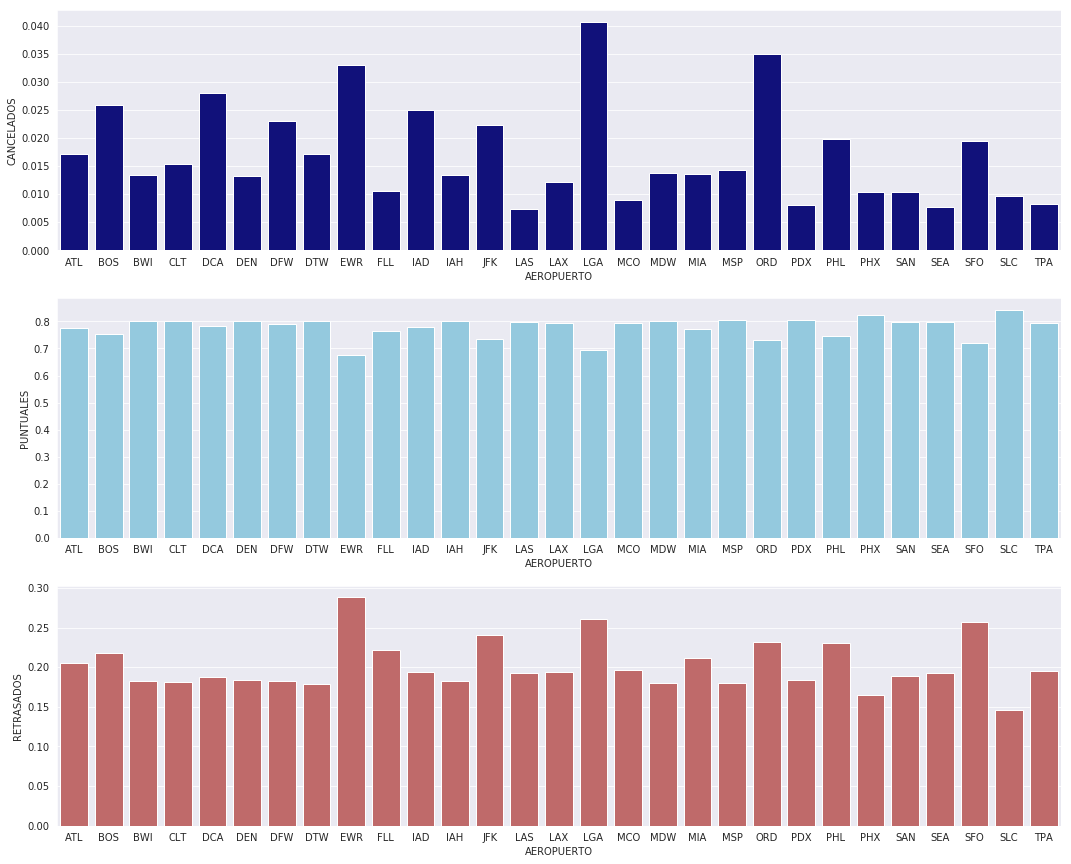

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15));

sns.barplot(x=df11.index, y= df11.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("CANCELADOS");
ax1.set_xlabel("AEROPUERTO");

sns.barplot(x=df11.index, y= df11.iloc[:,1], color= 'SkyBlue', ax=ax2);
ax2.set_ylabel("PUNTUALES");
ax2.set_xlabel("AEROPUERTO");

sns.barplot(x=df11.index, y= df11.iloc[:,2], color= 'IndianRed', ax=ax3);
ax3.set_ylabel("RETRASADOS");
ax3.set_xlabel("AEROPUERTO");

En los gráficos anteriores se aprecian los siguientes resultados interesantes:

- Los aeropuertos con más **cancelaciones promedio son LGA, ORD y EWR**
- Los aeropuertos con más **retrasos promedio son EWG, LGA y SFO**
- Los aeropuertos con **peor puntualidad son, como cabía esperar, **EWG, LGA y SFO**

Por otro lado,

- El aeropuerto con **mejor puntualidad y menores ratios de retrasos es SLC, que además posee un buen ratio en vuelos cancelados**.

Para saber el **nombre de los aeropuerto anteriores**, la siguiente consulta nos da la correspondencia entre los códigos de los anteriores aeropuertos y sus respectivos nombres.

- **Query 12**

In [10]:
curs12 = air.find(
                 {"airport.code": {"$in": ["LGA", "ORD", "EWR", "SFO"]}},
                 {"airport.code": 1, "airport.name": 1, "_id": 0}
).limit(4)

In [11]:
query12 = list(curs12)

In [12]:
query12

[{'airport': {'code': 'EWR',
   'name': 'Newark, NJ: Newark Liberty International'}},
 {'airport': {'code': 'LGA', 'name': 'New York, NY: LaGuardia'}},
 {'airport': {'code': 'ORD',
   'name': "Chicago, IL: Chicago O'Hare International"}},
 {'airport': {'code': 'SFO',
   'name': 'San Francisco, CA: San Francisco International'}}]

## 6.5 Causas más comunes de retraso durante el período de estudio

Nos interesa saber cuáles de las **causas principales de retraso son las más comunes en promedio** durante el período de estudio para lo cual se plantea la siguiente consulta.

- se filtran los años de interés
- se eliminan los documentos que poseen vuelos retrasados nulos
- se crean los campos que tienen en cuenta el cociente entre los vuelos retrasados debidos a una causa y los vuelos totales retrasados:

    - Ratio_late aircraft: retrasos asociado al aeronave
    - Ratio_weather: retrasos asociado al tiempo
    - Ratio_security: retrasos asociado a la seguridad
    - Ratio_national aviation system. : retrasos asociado al sistema de navegación aérea
    - Ratio_carrier: retrasos asociado al transportista
    
- Se calculan los valores promedio

- **Query13**

In [13]:
pipeline13 = [
    {"$match": {"time.year": {"$nin": [2003, 2016]},
                            "statistics.flights.delayed": {"$ne": 0}}}, #se quitan valores nulos
    {"$project": {"time.year": 1,    
        "Ratio_late aircraft": {"$divide": 
                    ["$statistics.# of delays.late aircraft", "$statistics.flights.delayed"]},
        "Ratio_weather": {"$divide": 
                    ["$statistics.# of delays.weather", "$statistics.flights.delayed"]},
        "Ratio_security": {"$divide": 
                    ["$statistics.# of delays.security", "$statistics.flights.delayed"]},
        "Ratio_national aviation system": {"$divide": 
                    ["$statistics.# of delays.national aviation system", "$statistics.flights.delayed"]},
        "Ratio_carrier": {"$divide": 
                    ["$statistics.# of delays.carrier", "$statistics.flights.delayed"]}}},
    {"$group": {"_id": "$time.year",
                       "late": {"$avg": "$Ratio_late aircraft"},
                       "weather": {"$avg": "$Ratio_weather"},
                       "security": {"$avg": "$Ratio_security"},
                       "system": {"$avg": "$Ratio_national aviation system"},
                       "carrier": {"$avg": "$Ratio_carrier"}
                }
    }
]

curs13 = db.airlines.aggregate(pipeline13)

In [14]:
query13 = list(curs13)

In [15]:
df13 = pd.DataFrame(query13).set_index("_id").sort_index()
df13.index.name = "year"
df13.index.values
df13

,carrier,late,security,system,weather
year,,,,,
"2,004.00",0.30,0.23,0.00,0.43,0.05
"2,005.00",0.32,0.24,0.00,0.40,0.04
"2,006.00",0.32,0.25,0.00,0.39,0.04
"2,007.00",0.33,0.26,0.00,0.38,0.04
"2,008.00",0.31,0.24,0.00,0.41,0.04
"2,009.00",0.30,0.25,0.00,0.42,0.03
"2,010.00",0.31,0.28,0.00,0.37,0.03
"2,011.00",0.31,0.28,0.00,0.38,0.03
"2,012.00",0.33,0.29,0.00,0.35,0.03


Si se representa gŕaficamente los resultados anteriores,

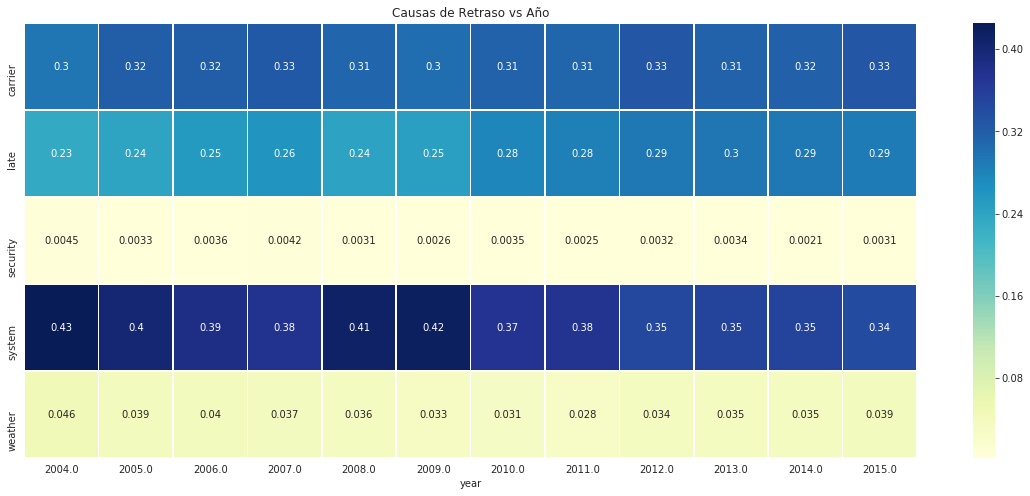

In [16]:
fig2, ax = plt.subplots(1, 1, figsize=(20,8));

ax = sns.heatmap(df13.T, annot=True, linewidths=.5, cmap="YlGnBu");
ax.set_title("Causas de Retraso vs Año");

Como se aprecia **la causa principal de retraso es debida a los sistemas de navegación aerea en todos los años de estudio estando en el intervalo del 30% al 45%**. Le siguen las **causas debidad al transportista y las debidas a la aeronave en el intervalo del 20% al 35%**.

Por el contrario, las **causas climatológicas y se seguridad** no llegan a representar ni un 5% ni un 1% respectivamente.


## 6.6 Causas más comunes de retraso durante el período de estudio para los aeropuertos con mayores retrasos

Anteriormente se obtuvo que **los aeropuertos con más retrasos promedio son EWG, LGA y SFO**. Si se quiere obtener **las principales causas** que, en promedio, han sido más frecuentes en el periodo de estudio, se ejecutaría la siguiente consulta:

- se filtran los años de interés
- se filtran los aeropueros **EWG, LGA y SFO**
- se crean los campos que tienen en cuenta el cociente entre los vuelos retrasados debidos a una causa y los vuelos totales retrasados:

    - Ratio_late aircraft: retrasos asociado al aeronave
    - Ratio_weather: retrasos asociado al tiempo
    - Ratio_security: retrasos asociado a la seguridad
    - Ratio_national aviation system. : retrasos asociado al sistema de navegación aérea
    - Ratio_carrier: retrasos asociado al transportista
    
- Se calculan los valores promedio

- **Query 14**

In [17]:
pipeline14 = [
    {"$match": {"time.year": {"$nin": [2003, 2016]},
                            "statistics.flights.delayed": {"$ne": 0}, #se quitan valores nulos
                            "airport.code": {"$in": ["LGA", "ORD", "EWR", "SFO"]}}}, 
    {"$project": {
                "airport.code": 1,    
                "Ratio_late aircraft": {"$divide": 
                            ["$statistics.# of delays.late aircraft", "$statistics.flights.delayed"]},
                "Ratio_weather": {"$divide": 
                            ["$statistics.# of delays.weather", "$statistics.flights.delayed"]},
                "Ratio_security": {"$divide": 
                            ["$statistics.# of delays.security", "$statistics.flights.delayed"]},
                "Ratio_national aviation system": {"$divide": 
                            ["$statistics.# of delays.national aviation system", 
                             "$statistics.flights.delayed"]},
                "Ratio_carrier": {"$divide": 
                            ["$statistics.# of delays.carrier", "$statistics.flights.delayed"]}}},
    {"$group": {"_id": "$airport.code",
                "late": {"$avg": "$Ratio_late aircraft"},
                "weather": {"$avg": "$Ratio_weather"},
                "security": {"$avg": "$Ratio_security"},
                "system": {"$avg": "$Ratio_national aviation system"},
                "carrier": {"$avg": "$Ratio_carrier"}
                }
    }
]

curs14 = db.airlines.aggregate(pipeline14)

In [18]:
query14 = list(curs14)

In [19]:
df14 = pd.DataFrame(query14).set_index("_id").sort_index()
df14.index.name = "Aeropuertos"
df14

,carrier,late,security,system,weather
Aeropuertos,,,,,
EWR,0.19,0.18,0.00,0.59,0.04
LGA,0.19,0.20,0.00,0.57,0.04
ORD,0.22,0.24,0.00,0.50,0.04
SFO,0.29,0.21,0.00,0.47,0.03


Si se representa gŕaficamente los resultados anteriores,

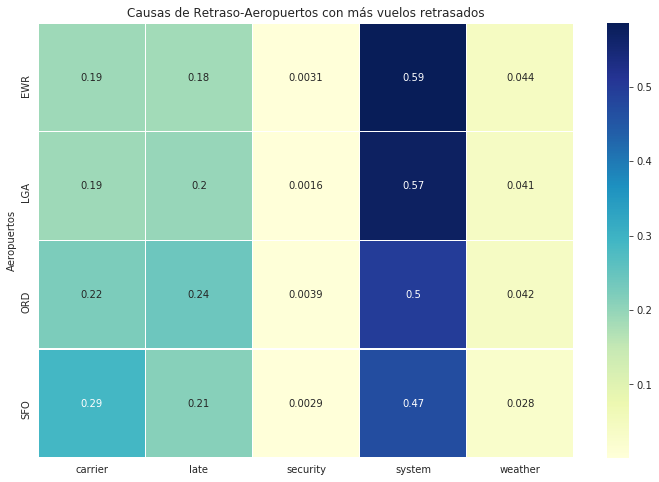

In [20]:
fig3, ax = plt.subplots(1, 1, figsize=(12,8));

ax = sns.heatmap(df14, annot=True, linewidths=.5, cmap="YlGnBu");
ax.set_title("Causas de Retraso-Aeropuertos con más vuelos retrasados");

Se observa que:

- en general estos aeropuertos **siguen los resultados anteriores en cuanto a principales causas de retraso**
- más del **47% de los retrasos en estos aeropuertos son debidos a los sistemas de navegación aérea**. 
- casi entre el **40% y 50% de los retrasos, dependiendo del aeropuerto, son debidas al transportista y al aeronave**    
    

## 6.7 Minutos de retraso promedio por aeropuerto y causa del retraso

También es interesante estudiar **la varible minutos de retraso asociada a una determinada causa** que da una idea de la importancia de los tipos de retraso, en términos de tiempo, en el que los vuelos no operaron a la hora prevista por dichas causas.

Nos preguntamos **qué aeropuertos poseen, en promedio, mayores minutos de retraso para una causa determinada**. Para ello se diseña la siguiente consulta:

- se filtran los años de estudio
- se agrupa por códico de aeropuerto
- se calculan los promedios de los minutos de retraso por causa de retraso

In [21]:
pipeline15 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": "$airport.code",
                         "totales": {"$avg": "$statistics.minutes delayed.total"},
                         "late": {"$avg": "$statistics.minutes delayed.late aircraft"},
                         "weather": {"$avg": "$statistics.minutes delayed.weather"},
                         "carrier": {"$avg": "$statistics.minutes delayed.carrier"},
                         "security": {"$avg": "$statistics.minutes delayed.security"},
                         "system": {"$avg": "$statistics.minutes delayed.national aviation system"}
                        },
             },
              {"$sort": {"totales": -1}}
            ]

curs15 = air.aggregate(pipeline15);

In [22]:
query15 = list(curs15)

In [23]:
df15 = pd.DataFrame(query15).set_index("_id")
df15.index.name = "Aeropuertos"
df15.columns.name = "Minutos Retraso Promedio"
df15.head(10)

Minutos Retraso Promedio,carrier,late,security,system,totales,weather
Aeropuertos,,,,,,
ORD,"6,541.20","11,579.74",24.35,"15,006.06","34,290.48","1,139.13"
ATL,"8,397.95","10,036.67",26.62,"11,382.94","31,473.75","1,629.57"
DFW,"5,533.13","8,176.96",20.43,"4,541.96","19,536.66","1,264.17"
EWR,"2,387.20","4,331.69",16.67,"10,674.62","18,037.61",627.43
SFO,"2,892.19","4,669.82",17.76,"6,795.59","14,816.98",441.62
IAH,"3,525.54","5,370.08",27.40,"4,462.51","14,080.77",695.24
JFK,"3,151.96","4,124.80",24.72,"5,981.23","13,898.33",615.61
DEN,"3,801.46","5,852.22",19.59,"3,159.31","13,441.95",609.36
LAX,"3,914.40","5,326.81",30.03,"2,895.24","12,637.60",471.11


Representando lo anterior de forma gráfica

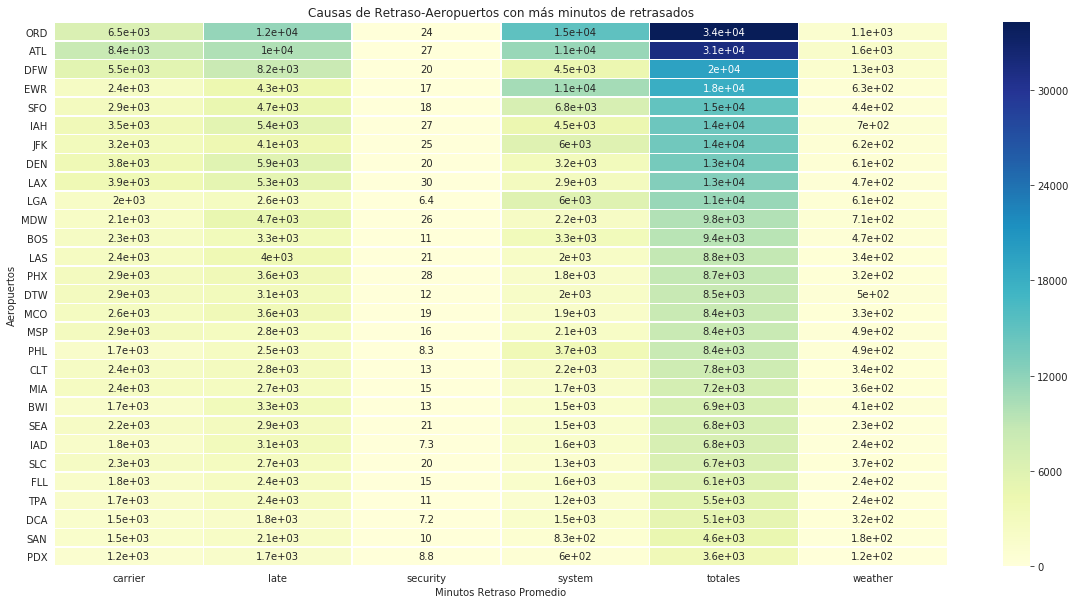

In [24]:
fig4, ax = plt.subplots(1, 1, figsize=(20, 10))

ax = sns.heatmap(df15, annot=True, linewidths=.5, cmap="YlGnBu");
ax.set_title("Causas de Retraso-Aeropuertos con más minutos de retrasados");

Se aprecia que los **tres primeros aeropueros (ORD, ATL, DFW) con más minutos promedio retrasados acumulados no son los tres primeros que más vuelos promedio retrasados tienen**. Para saber los nombres de estos tres:

- **Query 16**

In [25]:
curs16 = air.find(
                 {"airport.code": {"$in": ["ORD", "ATL", "DFW"]}},
                 {"airport.code": 1, "airport.name": 1, "_id": 0}
).limit(3)

In [26]:
query16 = list(curs16)

Con esto, se obtienen los nombres de los aeropuertos

In [27]:
query16

[{'airport': {'code': 'ATL',
   'name': 'Atlanta, GA: Hartsfield-Jackson Atlanta International'}},
 {'airport': {'code': 'DFW',
   'name': 'Dallas/Fort Worth, TX: Dallas/Fort Worth International'}},
 {'airport': {'code': 'ORD',
   'name': "Chicago, IL: Chicago O'Hare International"}}]

Nos podemos preguntar **si estos tres aeropuertos son los que mayor número de vuelos acumulados** han tenido durante el período de estudio.

- **Query 17**

In [28]:
pipeline17 = [{"$match": {"time.year": {"$nin": [2003, 2016]}}},
             {"$group": {"_id": "$airport.code", 
                        "Totales": {"$sum": "$statistics.flights.total"}, 
                        }
             },
             {"$sort": {"Totales": -1}}    
            ]
curs17 = air.aggregate(pipeline17)

In [29]:
query17 = list(curs17)

In [30]:
df17 = pd.DataFrame(query17).set_index("_id")
df17.index.name = "Aeropuertos"
df17.head(10)

,Totales
Aeropuertos,
ATL,"4,847,036.00"
ORD,"3,973,794.00"
DFW,"3,422,939.00"
DEN,"2,669,176.00"
LAX,"2,637,252.00"
IAH,"2,257,833.00"
PHX,"2,204,351.00"
LAS,"1,876,789.00"
SFO,"1,761,055.00"


Representando gráficamente los resultados, se confirma que los **aeropuertos con más minutos de retraso son los que mayor volumen de tráfico han tenido durante el período de estudio**.

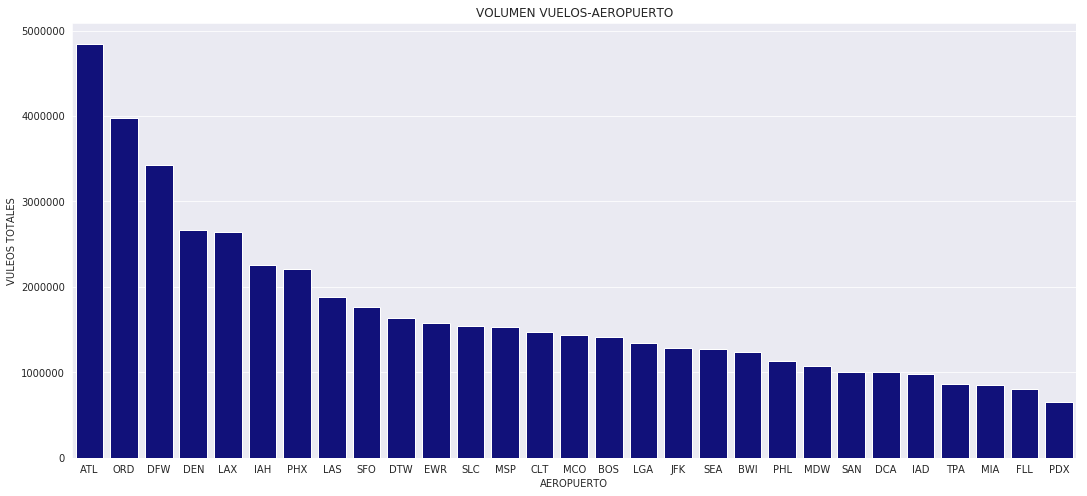

In [31]:
fig5, ax1 = plt.subplots(1, 1, figsize=(18,8));

sns.barplot(x=df17.index, y= df17.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("VULEOS TOTALES");
ax1.set_xlabel("AEROPUERTO");
ax1.set_title("VOLUMEN VUELOS-AEROPUERTO");

## 6.8 Evolución anual de Minutos de retraso para los aeropuertos de ORD, ATL y DFW.

En este apartado, se analiza la **evolución anual en el período de estudio de los minutos de retraso acumulados en los aeropuertos de ORD, ATL y DFW**. Se diseña la siguiente consulta:

- se filtra los años de estudio
- se filtran los aeropuertos de **ORD, ATL y DFW** 
- se calculan los minutos de retraso

- **Query 18**

In [32]:
pipeline18 = [{"$match": {"time.year": {"$nin": [2003, 2016]},
                        "airport.code": {"$in": ["ORD", "ATL", "DFW"]}}
              },
              {"$group": {"_id": {"Aeropuerto": "$airport.code", "Year": "$time.year"},
                         "Totales": {"$sum": "$statistics.minutes delayed.total"}
                        }
             },
              {"$project": {"Aeropuerto": "$_id.Aeropuerto",
                            "Year": "$_id.Year",
                            "Totales": "$Totales",
                            "_id": 0
                           }
              },
              {"$sort": {"Year": 1}}
            ]

curs18 = air.aggregate(pipeline18);

In [33]:
query18 = list(curs18)

In [34]:
df18 = pd.DataFrame(query18).set_index(["Year", "Aeropuerto"]).unstack()
df18

Totales                          
Aeropuerto          ATL          DFW          ORD
Year                                             
2,004.00   5,501,464.00 3,238,746.00 6,464,029.00
2,005.00   6,462,164.00 2,800,812.00 4,615,773.00
2,006.00   5,967,595.00 3,175,007.00 7,321,451.00
2,007.00   5,656,546.00 4,355,835.00 7,634,716.00
2,008.00   5,568,010.00 3,268,098.00 6,947,544.00
2,009.00   6,119,887.00 2,924,451.00 3,633,113.00
2,010.00   4,984,857.00 2,421,741.00 3,845,719.00
2,011.00   4,123,957.00 2,272,412.00 4,373,129.00
2,012.00   3,339,484.00 2,626,513.00 3,762,520.00
2,013.00   4,366,598.00 3,398,736.00 4,907,425.00
2,014.00   3,782,402.00 3,887,857.00 5,034,412.00
2,015.00   3,612,426.00 3,257,391.00 4,280,327.00

Representando la tabla anterior

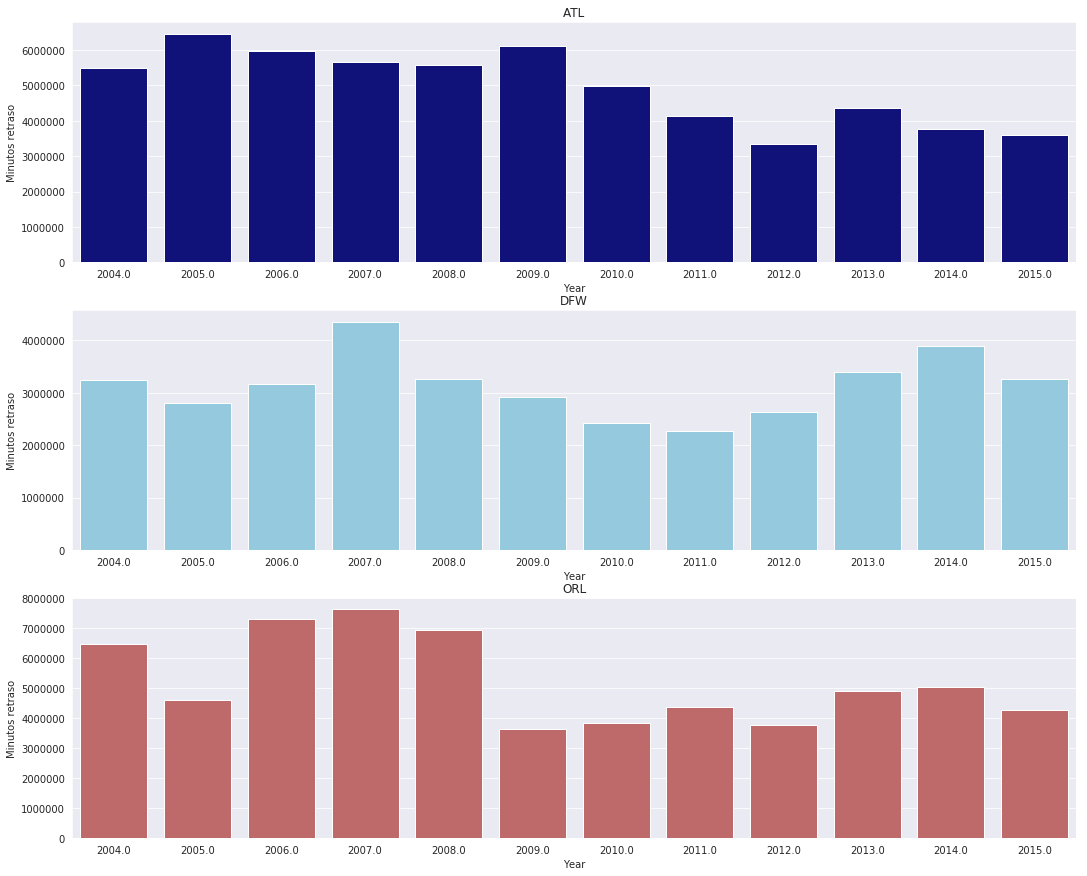

In [35]:
fig6, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15));

sns.barplot(x=df18.index, y= df18.iloc[:,0], color= "darkblue", ax=ax1);
ax1.set_ylabel("Minutos retraso");
ax1.set_xlabel("Year");
ax1.set_title("ATL");

sns.barplot(x=df18.index, y= df18.iloc[:,1], color= 'SkyBlue', ax=ax2);
ax2.set_ylabel("Minutos retraso");
ax2.set_xlabel("Year");
ax2.set_title("DFW");

sns.barplot(x=df18.index, y= df18.iloc[:,2], color= 'IndianRed', ax=ax3);
ax3.set_ylabel("Minutos retraso");
ax3.set_xlabel("Year");
ax3.set_title("ORL");

Se aprecia que:

- En el **aeropuerto de ATL parece que los minuos de retraso han descendido**
- En los **aeroperto de DFW y ORL parece que los minutos de retraso han crecido en los años 2013, 2014 y 2015 después de un período de descenso entre los años 2009, 2010, 2011 y 2012**. Este efecto es más pronunciado en DFW.

## 6.9 Evolución mensual entre 2014-2015 de los Minutos de retraso, Ratio de vuelos cancelados, Ratio de vuelos retrasados y vuelos totales para los aeropuertos de ORD, ATL y DFW.

En este apartado, se analiza la **evolución mensual de dichos indicadores durante los años 2014-2015 en los aeropuertos de ORD, ATL y DFW**. Se diseña la siguiente consulta:

- se filtra los años de estudio
- se filtran los aeropuertos de **ORD, ATL y DFW** 
- se calculan los indicadores 

- **Query 19**

In [36]:
pipeline19 = [{"$match": {"time.year": {"$in": [2014, 2015]},
                        "airport.code": {"$in": ["ORD", "ATL", "DFW"]}}
              },
              {"$group": {"_id": {"Aeropuerto": "$airport.code", 
                                  "Year": "$time.year",
                                  "Month": "$time.month"},
                         "minTotales": {"$sum": "$statistics.minutes delayed.total"},
                         "Totales": {"$sum": "$statistics.flights.total"},
                         "Cancelados": {"$sum": "$statistics.flights.cancelled"},
                         "Retrasados": {"$sum": "$statistics.flights.delayed"}
                        }
             },
              {"$project": {"Aeropuerto": "$_id.Aeropuerto",
                            "Year": "$_id.Year",
                            "Month": "$_id.Month",
                            "minTotales": "$minTotales",
                            "Ratio_Retrasados": {"$divide": ["$Retrasados", "$Totales"]},
                            "Ratio_Cancelados": {"$divide": ["$Cancelados", "$Totales"]},
                            "Vuelos_Totales": "$Totales",
                            "_id": 0
                           }
              },
              {"$sort": {"Year": 1, "Month": 1}}
            ]

curs19 = air.aggregate(pipeline19);

In [37]:
query19 = list(curs19)

In [38]:
df19 = pd.DataFrame(query19).set_index(["Year", "Month", "Aeropuerto"]).unstack()

Se crea el gráfico que nos da la **evolución de Vuelos Totales** en los tres aeropuertos seleccionados

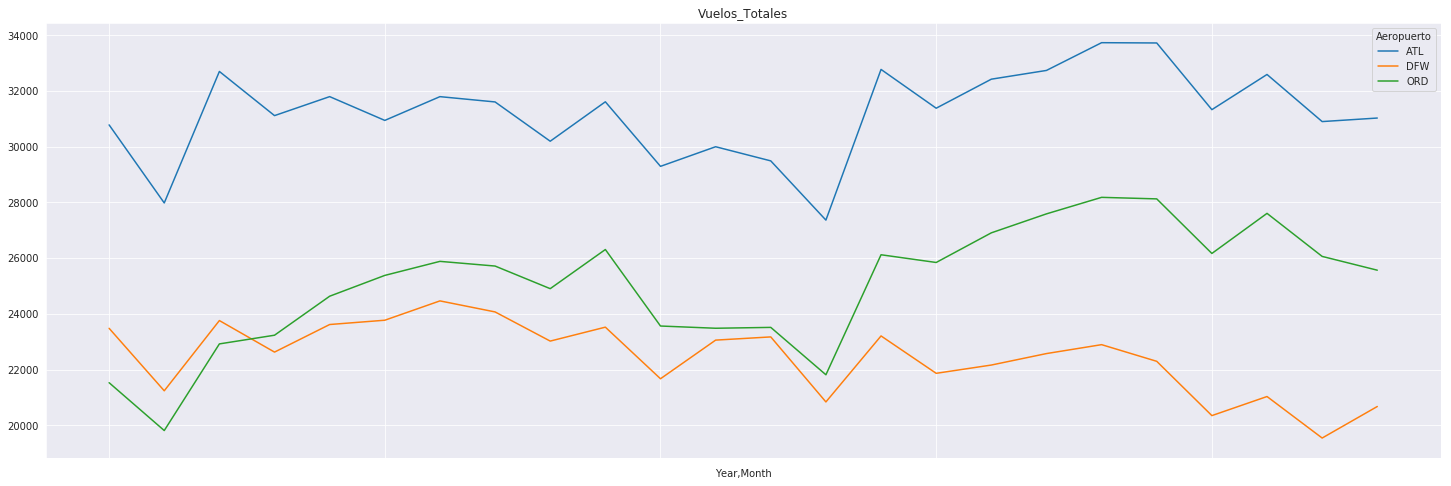

In [39]:
df19["Vuelos_Totales"].plot(kind= "line", figsize=(25,8), title = "Vuelos_Totales");

Se aprecia que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015:

- En **ATL crece ligeramente el número de vuelos**
- En **ORL crece el número de vuelos**
- En **DFW, al contrario que los dos anteriores, decrece el número de vuelos**
    

Para los **Ratios de los Vuelos Retrasados**

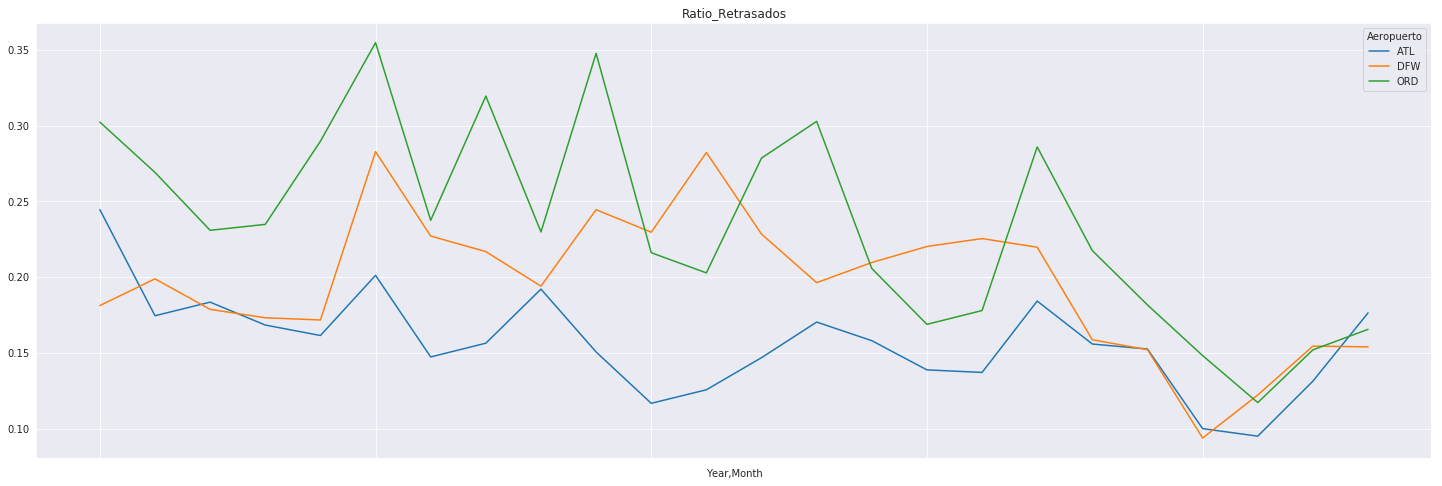

In [40]:
df19["Ratio_Retrasados"].plot(kind= "line", figsize=(25,8), title = "Ratio_Retrasados");

Parece que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015::

- En los **tres aeropuertos el Ratio de retrasados disminuye**.
    

Para los **Ratios de los Vuelos Retrasados**

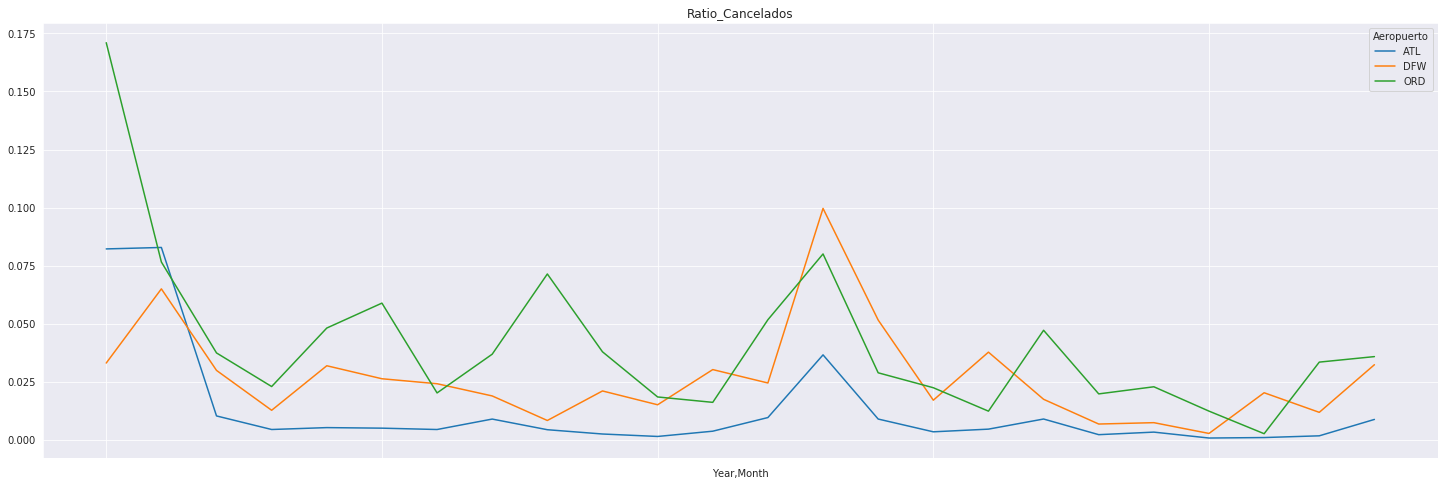

In [41]:
df19["Ratio_Cancelados"].plot(kind= "line", figsize=(25,8), title = "Ratio_Cancelados");

Parece que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015::
    
- En los **tres aeropuertos el Ratio de Cancelaciones permanece estable**.   

Para los **Minutos de retraso totales**

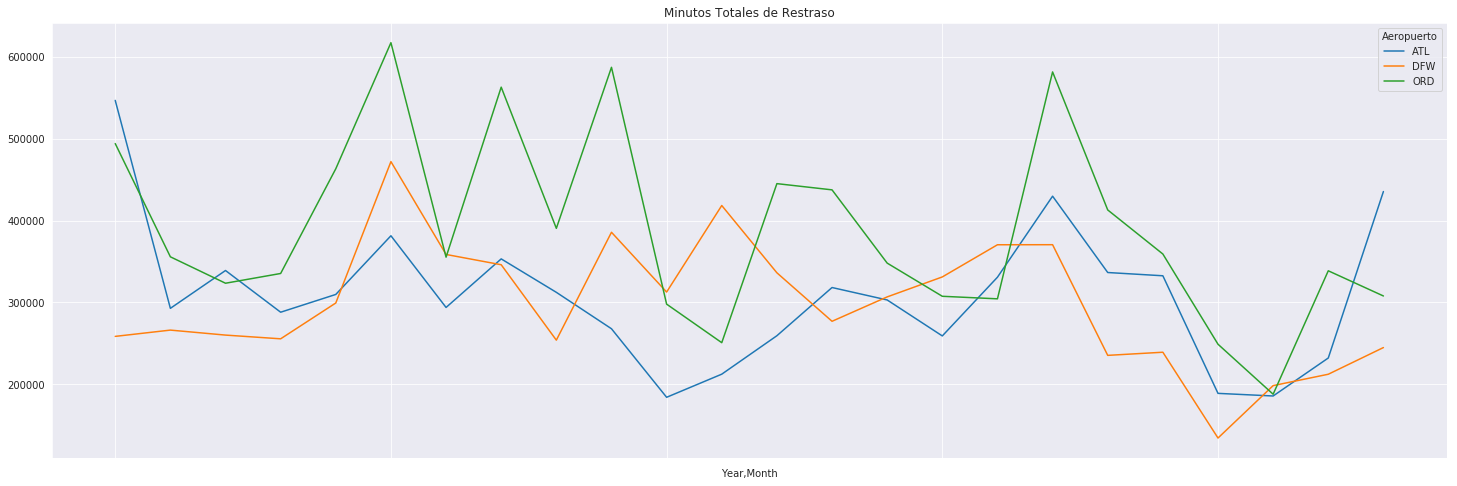

In [42]:
df19["minTotales"].plot(kind= "line", figsize=(25,8), title = "Minutos Totales de Restraso");

Parece que, de acuerdo con la tendencia y no teniendo en cuenta la estacionalidad, durante 2014-2015::
    
- En los **tres aeropuertos los minutos de retraso totales permanece ligeramente**.  